<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/cifar10_TrustScore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR10:
Original CIFAR10 [0: airplane, 1: automobile, 2: bird, 3: cat, 4: deer, 5: dog, 6: frog, 7: horse, 8: ship, 9: truck] <br>


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import os
import argparse
import copy
import random
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def seed_everything(seed=12):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
parser = argparse.ArgumentParser(description='BalancedLSF Training')
parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
parser.add_argument('--batch_size', default=1024, type=int, help='batch size')
parser.add_argument('--test_batch_size', default=2048, type=int, help='batch size')
parser.add_argument('--num_epoch', default=50, type=int, help='epoch number')
parser.add_argument('--num_classes', type=int, default=10, help='number classes')
args = parser.parse_args(args=[])

def train(model, trainloader, criterion, optimizer):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

Training

In [30]:
seed_everything()
mean_cifar10, std_cifar10 = (0.5071, 0.4866, 0.4409), (0.2009, 0.1984, 0.2023)
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(), transforms.ToTensor(),
            transforms.Normalize(mean_cifar10, std_cifar10), ])
transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean_cifar10, std_cifar10),])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=2)

model = models.resnet18().to(device)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model = model.to(device)

Files already downloaded and verified
Files already downloaded and verified


## This cell can be ignored if you wanna use the trained weights from next cell

In [ ]:

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, nesterov=False, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

best_epoch, best_acc = 0.0, 0
for epoch in range(args.num_epoch):
    train(model, train_loader, criterion, optimizer)
    accuracy = test(model, test_loader)
    if accuracy > best_acc:
        patience = 0
        best_acc = accuracy
        best_epoch = epoch
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), 'best_model_cifar10_lt.pth.tar')
    print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}'.format(
            epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0  acc: 0.3396  best epoch: 0  best acc: 0.3396
epoch: 1  acc: 0.4535  best epoch: 1  best acc: 0.4535
epoch: 2  acc: 0.4862  best epoch: 2  best acc: 0.4862
epoch: 3  acc: 0.5457  best epoch: 3  best acc: 0.5457
epoch: 4  acc: 0.5827  best epoch: 4  best acc: 0.5827
epoch: 5  acc: 0.6101  best epoch: 5  best acc: 0.6101
epoch: 6  acc: 0.6508  best epoch: 6  best acc: 0.6508
epoch: 7  acc: 0.6524  best epoch: 7  best acc: 0.6524
epoch: 8  acc: 0.6677  best epoch: 8  best acc: 0.6677
epoch: 9  acc: 0.6693  best epoch: 9  best acc: 0.6693
epoch: 10  acc: 0.6973  best epoch: 10  best acc: 0.6973
epoch: 11  acc: 0.7084  best epoch: 11  best acc: 0.7084
epoch: 12  acc: 0.7154  best epoch: 12  best acc: 0.7154
epoch: 13  acc: 0.7101  best epoch: 12  best acc: 0.7154
epoch: 14  acc: 0.7298  best epoch: 14  best acc: 0.7298
epoch: 15  acc: 0.7326  best epoch: 15  best acc: 0.7326
epoch: 16  acc: 0.7393  best epoch: 16  best acc: 0.7393
epoch: 17  acc: 0.7389  best epoch: 16  best acc: 0

Download trained model

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id = ['1rDyWMpo1RYa9wFx5gZsXf_mHMwCTr2oz']
downloaded = drive.CreateFile({'id':id[0]}) 
downloaded.GetContentFile('best_model_cifar10_lt.pth.tar')

## confusion matrix: scratch

In [4]:



def get_confusion_matrix(model, testloader):
    model.eval()
    confusion_matrix = torch.zeros(args.num_classes, args.num_classes)
    correct = 0
    total = 0
    acc_per_class = torch.zeros(args.num_classes)
    samples_per_class = torch.zeros(args.num_classes)
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(targets.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
            
            total += targets.size(0)
            correct_matrix = preds.eq(targets)
            correct += correct_matrix.sum().item()
            for cls in range (args.num_classes):
                acc_per_class[cls] += correct_matrix[targets==cls].sum().item()
                samples_per_class[cls] += (targets==cls).sum().item()

    return correct / total, confusion_matrix, acc_per_class/samples_per_class

def get_tp_tn_fp_fn(conf_matrix, nb_classes):
    TP = conf_matrix.diag()
    for c in range(nb_classes):
        idx = torch.ones(nb_classes).byte()
        idx[c] = 0
        # all non-class samples classified as non-class
        TN = conf_matrix[idx.nonzero()[:, None], idx.nonzero()].sum() #conf_matrix[idx[:, None], idx].sum() - conf_matrix[idx, c].sum()
        # all non-class samples classified as class
        FP = conf_matrix[idx, c].sum()
        # all class samples not classified as class
        FN = conf_matrix[c, idx].sum()
        
        print('Class {}\nTP {}, TN {}, FP {}, FN {}, acc={}, recall={}, prec={}, total= {}'.format(
            c, TP[c], TN, FP, FN,(TP[c]+TN)/(TP[c]+TN+FP+FN), TP[c]/(TP[c]+FN), TP[c]/(TP[c]+FP), (TP[c]+TN+FP+FN) ))
    

model.load_state_dict(torch.load('best_model_cifar10_lt.pth.tar'))
acc, confusion_matrix, acc_per_class = get_confusion_matrix(model, test_loader)
print('confusion matrix:\n', confusion_matrix)
class_wise_acc = confusion_matrix.diag()/confusion_matrix.sum(1)
print('per-class accuracy from CM:', class_wise_acc)
print('per-class accuracy from scratch:', acc_per_class)
print('accuracy-with CM:',class_wise_acc.mean(), ',directly:',acc)

get_tp_tn_fp_fn(confusion_matrix, args.num_classes)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


confusion matrix:
 tensor([[855.,   6.,  44.,  11.,   9.,   3.,   6.,   4.,  43.,  19.],
        [ 22., 905.,   7.,   5.,   1.,   1.,   3.,   0.,  16.,  40.],
        [ 28.,   1., 841.,  24.,  43.,  13.,  29.,   9.,   6.,   6.],
        [ 20.,   3., 109., 666.,  33.,  65.,  49.,  28.,  10.,  17.],
        [ 12.,   1.,  62.,  60., 752.,   8.,  45.,  53.,   5.,   2.],
        [ 12.,   0.,  96., 203.,  33., 579.,  19.,  46.,   7.,   5.],
        [  4.,   4.,  41.,  50.,  15.,   8., 870.,   3.,   3.,   2.],
        [ 15.,   1.,  44.,  44.,  20.,  10.,   1., 848.,   6.,  11.],
        [ 43.,  12.,   8.,   8.,   3.,   1.,   5.,   2., 908.,  10.],
        [ 39.,  48.,   7.,   5.,   0.,   2.,   5.,   2.,  20., 872.]])
per-class accuracy from CM: tensor([0.8550, 0.9050, 0.8410, 0.6660, 0.7520, 0.5790, 0.8700, 0.8480, 0.9080,
        0.8720])
per-class accuracy from scratch: tensor([0.8550, 0.9050, 0.8410, 0.6660, 0.7520, 0.5790, 0.8700, 0.8480, 0.9080,
        0.8720])
accuracy-with CM: tensor(

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:30.)


# TrustScore

In [31]:
import numpy as np
from sklearn.neighbors import KDTree, KNeighborsClassifier


class TrustScore:
    """
    Trust Score: a measure of classifier uncertainty based on nearest neighbors.
  """

    def __init__(self, k=10, alpha=0.0, filtering="none", min_dist=1e-12):
        """
        k and alpha are the tuning parameters for the filtering,
        filtering: method of filtering. option are "none", "density",
        "uncertainty"
        min_dist: some small number to mitigate possible division by 0.
    """
        self.k = k
        self.filtering = filtering
        self.alpha = alpha
        self.min_dist = min_dist

    def filter_by_density(self, X: np.array):
        """Filter out points with low kNN density.
    Args:
    X: an array of sample points.
    Returns:
    A subset of the array without points in the bottom alpha-fraction of
    original points of kNN density.
    """
        kdtree = KDTree(X)
        knn_radii = kdtree.query(X, k=self.k)[0][:, -1]
        eps = np.percentile(knn_radii, (1 - self.alpha) * 100)
        return X[np.where(knn_radii <= eps)[0], :]

    def filter_by_uncertainty(self, X: np.array, y: np.array):
        """Filter out points with high label disagreement amongst its kNN neighbors.
    Args:
    X: an array of sample points.
    Returns:
    A subset of the array without points in the bottom alpha-fraction of
    samples with highest disagreement amongst its k nearest neighbors.
    """
        neigh = KNeighborsClassifier(n_neighbors=self.k)
        neigh.fit(X, y)
        confidence = neigh.predict_proba(X)
        cutoff = np.percentile(confidence, self.alpha * 100)
        unfiltered_idxs = np.where(confidence >= cutoff)[0]
        return X[unfiltered_idxs, :], y[unfiltered_idxs]

    def fit(self, X: np.array, y: np.array):
        """Initialize trust score precomputations with training data.
    WARNING: assumes that the labels are 0-indexed (i.e.
    0, 1,..., n_labels-1).
    Args:
    X: an array of sample points.
    y: corresponding labels.
    """

        self.n_labels = np.max(y) + 1
        self.kdtrees = [None] * self.n_labels
        if self.filtering == "uncertainty":
            X_filtered, y_filtered = self.filter_by_uncertainty(X, y)
        for label in range(self.n_labels):
            if self.filtering == "none":
                X_to_use = X[np.where(y == label)[0]]
                self.kdtrees[label] = KDTree(X_to_use)
            elif self.filtering == "density":
                X_to_use = self.filter_by_density(X[np.where(y == label)[0]])
                self.kdtrees[label] = KDTree(X_to_use)
            elif self.filtering == "uncertainty":
                X_to_use = X_filtered[np.where(y_filtered == label)[0]]
                self.kdtrees[label] = KDTree(X_to_use)

            if len(X_to_use) == 0:
                print(
                    "Filtered too much or missing examples from a label! Please lower "
                    "alpha or check data."
                )

    def get_score(self, X: np.array, y_pred: np.array):
        """Compute the trust scores.
    Given a set of points, determines the distance to each class.
    Args:
    X: an array of sample points.
    y_pred: The predicted labels for these points.
    Returns:
    The trust score, which is ratio of distance to closest class that was not
    the predicted class to the distance to the predicted class.
    """
        d = np.tile(None, (X.shape[0], self.n_labels))
        for label_idx in range(self.n_labels):
            d[:, label_idx] = self.kdtrees[label_idx].query(X, k=2)[0][:, -1]

        sorted_d = np.sort(d, axis=1)
        d_to_pred = d[range(d.shape[0]), y_pred]
        d_to_closest_not_pred = np.where(
            sorted_d[:, 0] != d_to_pred, sorted_d[:, 0], sorted_d[:, 1]
        )
        return d_to_closest_not_pred / (d_to_pred + self.min_dist)


class KNNConfidence:
    """Baseline which uses disagreement to kNN classifier.
  """

    def __init__(self, k=10):
        self.k = k

    def fit(self, X, y):
        self.kdtree = KDTree(X)
        self.y = y

    def get_score(self, X, y_pred):
        knn_idxs = self.kdtree.query(X, k=self.k)[1]
        knn_outputs = self.y[knn_idxs]
        return np.mean(
            knn_outputs == np.transpose(np.tile(y_pred, (self.k, 1))), axis=1
        )





Validate on trustscore (V1):

Accuracy: 0.8096
Trust Score for First 2 Samples: [0.9062759867500153, 1.0645652828689323]


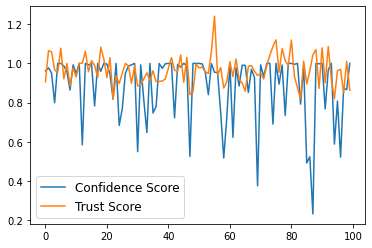

In [43]:
import matplotlib.pyplot as plt

def fit_trust_model(trust_model, testloader):
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs_array = np.array(inputs.view(inputs.shape[0], -1).cpu())
            targets_array = np.array(targets.cpu())
            trust_model.fit(inputs_array, targets_array)
        
    return trust_model

def test_trust_score(model, trust_model, testloader):
    model.eval()
    correct = 0
    total = 0
    trust_score_all = []
    confidence_all = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = F.softmax(outputs, dim=1)
            conf, predicted = outputs.max(1)
            confidence_all.extend(np.array(conf.cpu()))
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # ========= Get Trust Score ============ #
            inputs_array = np.array(inputs.view(inputs.shape[0], -1).cpu())
            predicted_array = np.array(predicted.cpu())
            trust_score = trust_model.get_score(inputs_array, predicted_array)
            trust_score_all.extend(trust_score)
        
        acc = correct / total 
    return acc, trust_score_all, confidence_all

trust_model = TrustScore()
trust_model = fit_trust_model(trust_model, test_loader)

model.load_state_dict(torch.load('best_model_cifar10_lt.pth.tar'))
acc, trust_score_all, confidence_all = test_trust_score(model, trust_model, test_loader)
print('Accuracy:', acc)
print('Trust Score for First 2 Samples:',trust_score_all[:2] )

plt.plot(confidence_all[:100], label='Confidence Score')
plt.plot(trust_score_all[:100], label='Trust Score')
plt.legend(loc="lower left", fontsize=12)

Validate on trustscore (V2):

Processed data: (10000, 3072) (10000,)
Accuracy: 0.8096
Trust Score for First 2 Samples: [0.9431595669648173, 1.2162421698977732]


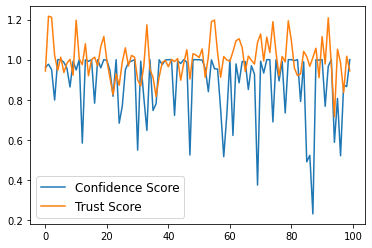

In [44]:
def get_data_processed(testloader):
    with torch.no_grad():
        inputs_array_all = []
        targets_array_all = []
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs_array = np.array(inputs.view(inputs.shape[0], -1).cpu())
            targets_array = np.array(targets.cpu())
            inputs_array_all.extend(inputs_array)
            targets_array_all.extend(targets_array)

        return inputs_array_all, targets_array_all

def test_trust_score(model, trust_model, testloader):
    model.eval()
    correct = 0
    total = 0
    trust_score_all = []
    confidence_all = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = F.softmax(outputs, dim=1)
            conf, predicted = outputs.max(1)
            confidence_all.extend(np.array(conf.cpu()))
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # ========= Get Trust Score ============ #
            inputs_array = np.array(inputs.view(inputs.shape[0], -1).cpu())
            predicted_array = np.array(predicted.cpu())
            trust_score = trust_model.get_score(inputs_array, predicted_array)
            trust_score_all.extend(trust_score)
        
        acc = correct / total 
    return acc, trust_score_all, confidence_all


trust_model = TrustScore()
inputs_array_all, targets_array_all = get_data_processed(test_loader)
print('Processed data:',np.array(inputs_array_all).shape, np.array(targets_array_all).shape)
trust_model.fit(np.array(inputs_array_all), np.array(targets_array_all))

model.load_state_dict(torch.load('best_model_cifar10_lt.pth.tar'))
acc, trust_score_all, confidence_all = test_trust_score(model, trust_model, test_loader)
print('Accuracy:', acc)
print('Trust Score for First 2 Samples:',trust_score_all[:2] )

plt.plot(confidence_all[:100], label='Confidence Score')
plt.plot(trust_score_all[:100], label='Trust Score')
plt.legend(loc="lower left", fontsize=12)

Validate on trustscore (V3):

Accuracy: 0.8096
Trust Score for First 2 Samples: [1.0244807582711073 1.0753678777737252]


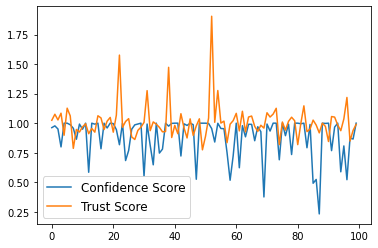

In [45]:
model.load_state_dict(torch.load('best_model_cifar10_lt.pth.tar'))
trust_model = TrustScore()


def test_trust_score(model, testloader):
    model.eval()
    correct = 0
    total = 0
    trust_score_all = []
    confidence_all = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = F.softmax(outputs, dim=1)
            conf, predicted = outputs.max(1)
            confidence_all.extend(np.array(conf.cpu()))
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # ========= Get Trust Score ============ #
            # prepare array format
            inputs_array = np.array(inputs.view(inputs.shape[0], -1).cpu())
            predicted_array = np.array(predicted.cpu())
            targets_array = np.array(targets.cpu())
  
            trust_model.fit(inputs_array, targets_array)
            # Compute trusts score, given (unlabeled) testing examples and (hard) model predictions.
            #print(inputs_array.shape, predicted_array.shape)
            trust_score = trust_model.get_score(inputs_array, predicted_array)
            #print('trust_score of one-batch data', trust_score)
            trust_score_all.extend(trust_score)
            # ========================================= #
    return correct / total, trust_score, confidence_all
acc, trust_score_all, confidence_all = test_trust_score(model, test_loader)
print('Accuracy:', acc)
print('Trust Score for First 2 Samples:',trust_score_all[:2] )

plt.plot(confidence_all[:100], label='Confidence Score')
plt.plot(trust_score_all[:100], label='Trust Score')
plt.legend(loc="lower left", fontsize=12)

# Fit trust_model with Trainset:

Processed data: (50000, 3072) (50000,)
Accuracy: 0.8096
Trust Score for First 2 Samples: [0.9541668557432996, 0.9338471275166986]


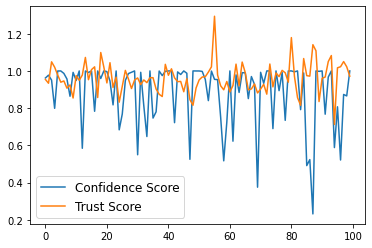

In [46]:
def get_data_processed(testloader):
    with torch.no_grad():
        inputs_array_all = []
        targets_array_all = []
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs_array = np.array(inputs.view(inputs.shape[0], -1).cpu())
            targets_array = np.array(targets.cpu())
            inputs_array_all.extend(inputs_array)
            targets_array_all.extend(targets_array)

        return inputs_array_all, targets_array_all

def test_trust_score(model, trust_model, testloader):
    model.eval()
    correct = 0
    total = 0
    trust_score_all = []
    confidence_all = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = F.softmax(outputs, dim=1)
            conf, predicted = outputs.max(1)
            confidence_all.extend(np.array(conf.cpu()))
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # ========= Get Trust Score ============ #
            inputs_array = np.array(inputs.view(inputs.shape[0], -1).cpu())
            predicted_array = np.array(predicted.cpu())
            trust_score = trust_model.get_score(inputs_array, predicted_array)
            trust_score_all.extend(trust_score)
        
        acc = correct / total 
    return acc, trust_score_all, confidence_all


trust_model = TrustScore()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False,num_workers=2)
inputs_array_all, targets_array_all = get_data_processed(train_loader)
print('Processed data:',np.array(inputs_array_all).shape, np.array(targets_array_all).shape)
trust_model.fit(np.array(inputs_array_all), np.array(targets_array_all))

model.load_state_dict(torch.load('best_model_cifar10_lt.pth.tar'))
acc, trust_score_all, confidence_all = test_trust_score(model, trust_model, test_loader)
print('Accuracy:', acc)
print('Trust Score for First 2 Samples:',trust_score_all[:2] )

plt.plot(confidence_all[:100], label='Confidence Score')
plt.plot(trust_score_all[:100], label='Trust Score')
plt.legend(loc="lower left", fontsize=12)